In [8]:
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import time # For timing

from qcml.manifolds import CircleManifold
from qcml.manifolds import SphereManifold
from qcml.matrix_trainer import MatrixConfigurationTrainer
from qcml.dimension_estimator import DimensionEstimator
from qcml.visualization.manifold_plots import (
    plot_3d_points,
    plot_pointwise_eigenvalues, # Function to plot eigenvalues vs point index
    plot_2d_reconstruction, # Added for Supplementary Figure 1
    compare_original_vs_reconstructed,
)

from qcml.visualization.training_plots import plot_training_curves

In [9]:
# Common parameters
N = 4
D = 3 # Embedding dimension for sphere
true_dim = 2
n_points_train = 2500
manifold_noise_std = 0.1 # Specific to this test (noiseless)

# Parameters for noise=0 case
n_epochs = 100
learning_rate = 0.01
w_qf = 0.2 # Set w_qf to 0.0 for the noiseless case (based on Figure 2 in paper)
batch_size = 500

output_dir = Path("./test_outputs/figure1")
output_dir.mkdir(parents=True, exist_ok=True)

# Set random seeds for reproducibility
seed = 42

In [10]:
# --- Data Generation ---
print(f"Generating {n_points_train} training points with noise std = {manifold_noise_std}...")
manifold = SphereManifold(dimension=D, noise=manifold_noise_std)
train_points = manifold.generate_points(n_points_train,np_seed=seed)

Generating 2500 training points with noise std = 0.1...


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: title={'center': 'Input Training Data X (noise = 0.1)'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

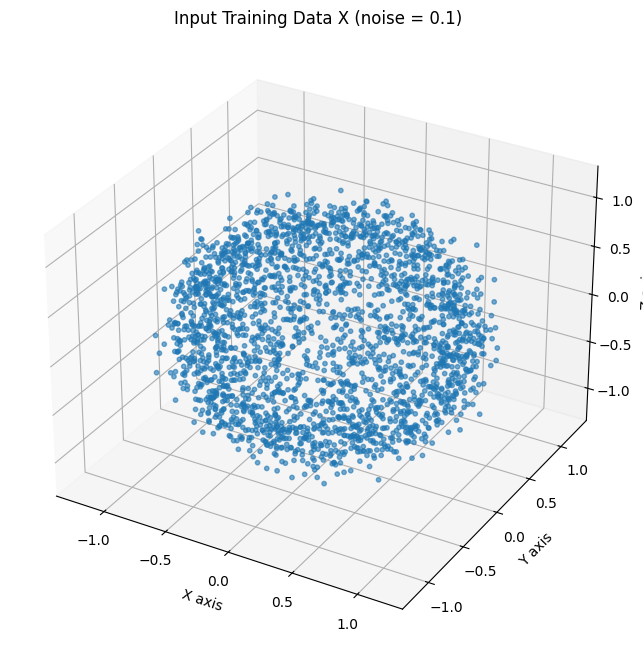

In [11]:
#input_plot_filename = f"fig1_a_input_points.png"
#save_path=output_dir / input_plot_filename
plot_3d_points(
    train_points, # Convert for plotting
    title=f"Input Training Data X (noise = {manifold_noise_std})"
)

In [12]:
trainer = MatrixConfigurationTrainer(
    N=N,
    D=D,
    points_np=train_points,
    learning_rate=learning_rate,
    quantum_fluctuation_weight=w_qf
)

--- Device Setup ---
CUDA Available: False
Using device: cpu
--------------------
[TIME] Device setup took: 0.0030s
[TIME] TOTAL __init__ setup before matrix init: 0.0031s
[TIME] Matrix initialization took: 0.0738s
[TIME] Moving model to device took: 0.0022s
[MatrixTrainer Init] Trainer using device: cpu
[MatrixTrainer Init] Parameter matrix device: cpu
[TIME] Optimizer init took: 1.2207s
[TIME] TOTAL __init__ took: 1.2999s
--- Stored 2500 points on device: cpu ---


In [13]:
history = trainer.train_matrix_configuration(
    n_epochs=n_epochs,
    batch_size=batch_size,
    verbose=True
)

[Train] Using stored tensor with 2500 points on device: cpu
--- Using mini-batch training (batch size = 500) ---
Epoch 1/100, Loss: 0.459946, Recon: 0.365990, QF: 0.469777, LR: 0.010000
Epoch 11/100, Loss: 0.174478, Recon: 0.061145, QF: 0.566662, LR: 0.010000
Epoch 21/100, Loss: 0.165915, Recon: 0.056726, QF: 0.545942, LR: 0.010000
Epoch 31/100, Loss: 0.165386, Recon: 0.056438, QF: 0.544736, LR: 0.010000
Epoch 41/100, Loss: 0.165053, Recon: 0.055980, QF: 0.545365, LR: 0.010000
Epoch 51/100, Loss: 0.164765, Recon: 0.055469, QF: 0.546480, LR: 0.010000
Epoch 61/100, Loss: 0.164633, Recon: 0.054953, QF: 0.548403, LR: 0.010000
Epoch 71/100, Loss: 0.164479, Recon: 0.055173, QF: 0.546531, LR: 0.010000
Epoch 81/100, Loss: 0.164448, Recon: 0.055260, QF: 0.545939, LR: 0.010000
Epoch 91/100, Loss: 0.164428, Recon: 0.055042, QF: 0.546931, LR: 0.010000
Epoch 100/100, Loss: 0.164419, Recon: 0.055177, QF: 0.546211, LR: 0.010000


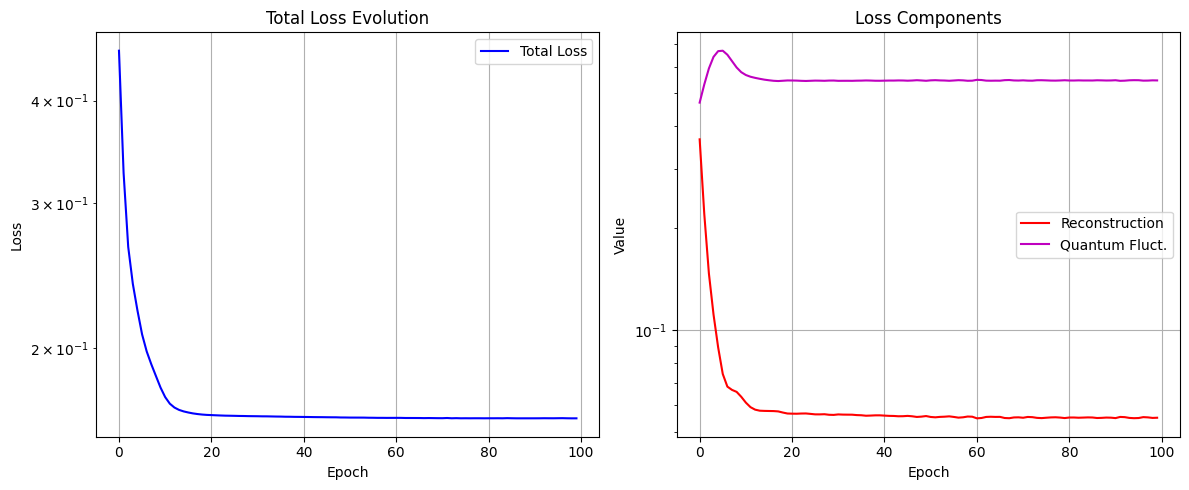

(<Figure size 1200x500 with 2 Axes>,
 [<Axes: title={'center': 'Total Loss Evolution'}, xlabel='Epoch', ylabel='Loss'>,
  <Axes: title={'center': 'Loss Components'}, xlabel='Epoch', ylabel='Value'>])

In [14]:
# plot training curves
plot_training_curves(history)

--- Reconstructing points provided during initialization. ---


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: title={'center': 'Reconstructed Points'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

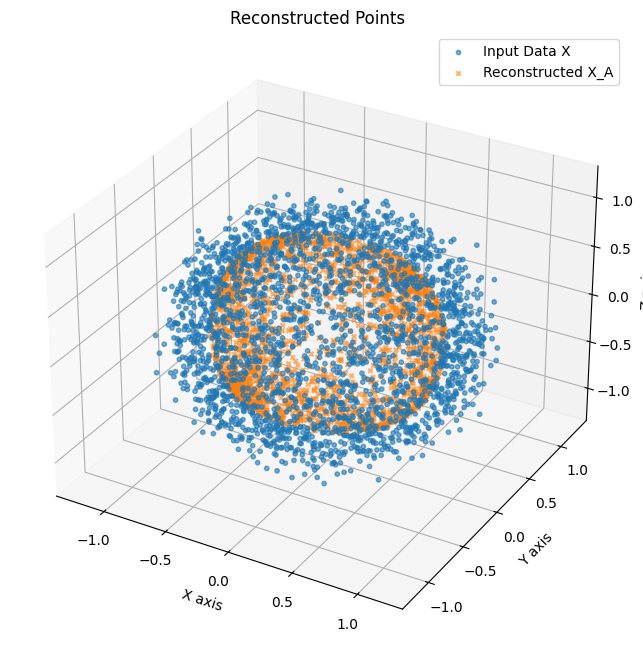

In [15]:
reconstructed_points = trainer.reconstruct_points() 

plot_3d_points(
    train_points,
    reconstructed_points,
    title=f"Reconstructed Points"
)

In [17]:
estimator = DimensionEstimator(trainer)
eigenvalues = estimator.compute_eigenspectrum(train_points)
if eigenvalues is not None and eigenvalues.shape[1] > 2:
    print(f"Noise={manifold_noise_std}, Eigenvalues shape: {eigenvalues.shape}, e2 min/max/mean: {eigenvalues[:, 2].min():.4f}/{eigenvalues[:, 2].max():.4f}/{eigenvalues[:, 2].mean():.4f}")

Computing quantum metrics first...

Computing quantum metrics (Vectorized Sum-over-States Eq. 7) for 2500 points (N=4, D=3)...
--- Computing eigensystem for provided 2500 points. ---
Quantum metrics (Internal Tensor Sum-over-States Eq. 7) computation completed.
Computing eigenvalues for metrics tensor shape: torch.Size([2500, 3, 3])
Computed eigenvalues shape: torch.Size([2500, 3])
Noise=0.1, Eigenvalues shape: torch.Size([2500, 3]), e2 min/max/mean: 0.2731/2.6075/1.0772
